In [63]:
# Homework 5 (due 07/31/2024)

# SVM and Kernels

### Objective
Through this project, you will learn to use nonlinear kernels to improve a support vector classifier. The toy examples within this project aim to guide you as you build your intuition for the decision boundaries that can be generated via different kernels.

This project is structured as follows:
#### Part 1: Binary classification of synthetic data
1.1. Generate and explore synthetic data

1.2. SVM with nonlinear kernels
#### Part 2: US Flags
2.1. Load and explore flags data

2.2. SVMs for flag pixel data

2.3. Comparison to decision trees


In [64]:
# standard imports
import os, random
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.datasets import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

# you may need to install the PIL in your environment
# for installation in mamba environment type "mamba install pillow -c conda-forge" in your miniforge prompt
# for installation in conda environment type "conda install pillow -c conda-forge" in your conda prompt or anaconda prompt
# for installation via pip type "pip install pillow" in your terminal
from PIL import Image

## Part 1: Binary classification of synthetic data

### Part 1.1: Generate and explore synthetic data
The next cell defines the function `generate_dataset`, which you can use to generate synthetic (i.e., computer generated) data sets for binary classification. It includes eight different methods for data-set generation. 
1. Try out each method and visualize the resulting data set. For the 'swiss' and 'scurve' data sets, try out two different values of the keyword argument `splits`.
2. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a linear classifier.
3. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a nonlinear classifier.

In [65]:
# Function to convert an array of real numbers into an array of 0s and 1s
def binarize(arr, split=10):
    # Calculate the decile thresholds
    percentiles = int(np.ceil(100/split))
    split_points = np.arange(0, 100+percentiles, percentiles)
    split_points[split_points>100] = 100
    deciles = np.percentile(arr, split_points)
    
    # Create a new array to hold the modified values
    modified_arr = np.zeros_like(arr)
    
    # Iterate through each decile range and set values accordingly
    for i in range(split):
        print(i)
        if i == split-1:
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i])] = 1
        else:        
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 1
    
    return modified_arr

# Function to generate datasets
def generate_dataset(dataset_type, n_samples=300, noise=0.1, split=10, random_state=0):
    if dataset_type == 'linearly_separable':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                                   random_state=random_state, n_clusters_per_class=1)
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=[n_samples//2, n_samples//2], random_state=random_state, cluster_std=noise)
    elif dataset_type == 'quantiles':
        X, y = make_gaussian_quantiles(n_samples=n_samples, n_classes=2, cov=noise, random_state=random_state)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
    elif dataset_type == 'unstructured':
        X, y = np.random.random(size=(n_samples, 2)), np.random.randint(0,2, size=(n_samples))
    elif dataset_type == 'swiss':
        X, y = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    elif dataset_type == 'scurve':
        X, y = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    else:
        raise ValueError("Invalid dataset type")
    
    X = StandardScaler().fit_transform(X)
    return X, y

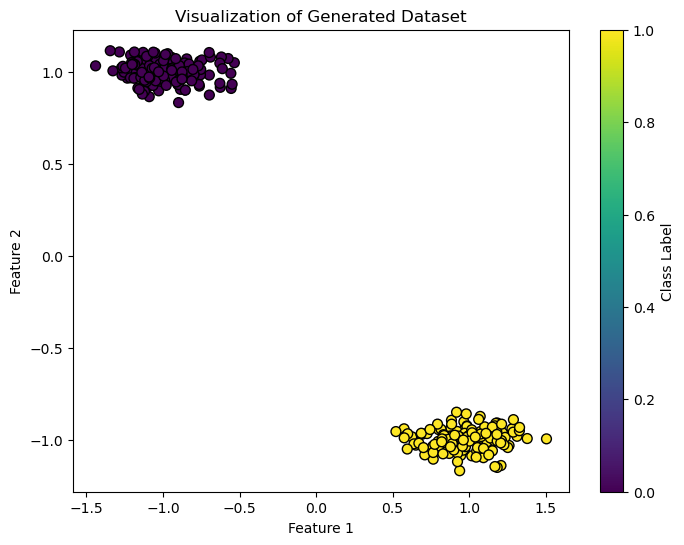

In [66]:
# Generate and visualize data blobs
blobsX, blobsY = generate_dataset(dataset_type='blobs')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(blobsX[:, 0], blobsX[:, 1], c=blobsY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set will be very easy to classify with a variety of lines, as there are two clear clusters of points.

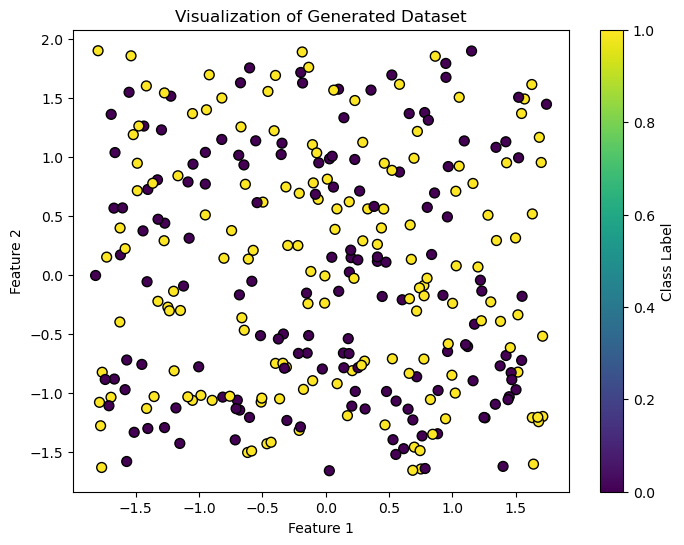

In [67]:
# Generate and visualize unstructured data
unstructuredX, unstructuredY = generate_dataset(dataset_type='unstructured')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(unstructuredX[:, 0], unstructuredX[:, 1], c=unstructuredY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set will be very hard to classify with a linear classifier, as both classes are very spread out and noisy, and points of both classes overlap with no clear pattern. Even with a non-linear classifier it would be a challenge, the dataset is too chaotic for any pattern to emerge.

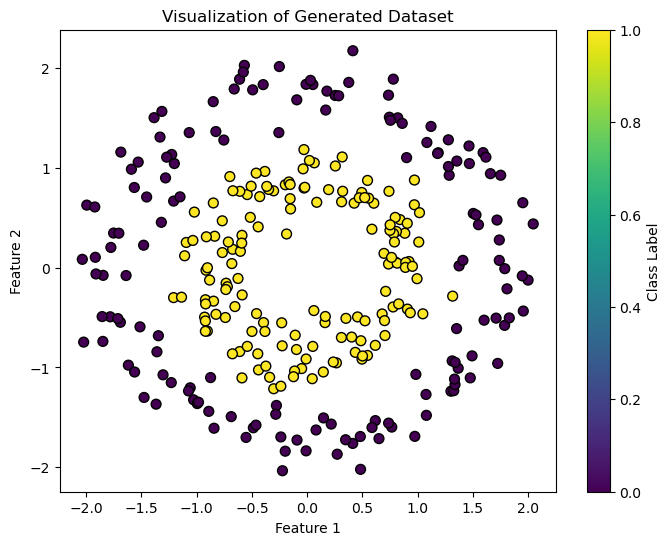

In [68]:
# Generate and visualize circles data set
circlesX, circlesY = generate_dataset(dataset_type='circles')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(circlesX[:, 0], circlesX[:, 1], c=circlesY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set will be hard to classify linearly, but easy to classify non-linearly. I think parabolic SVM kernel trick would work great on this.

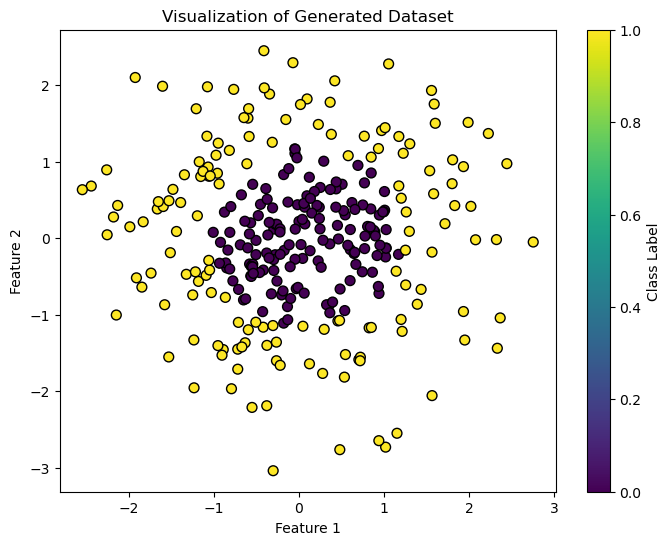

In [69]:
# Generate and visualize Gaussian quantiles
quantilesX, quantilesY = generate_dataset(dataset_type='quantiles')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(quantilesX[:, 0], quantilesX[:, 1], c=quantilesY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### Same as with the 'circles' dataset, I anticipate that this data set will be hard to classify linearly, but easy to classify non-linearly. I think parabolic SVM kernel trick would work great on this.

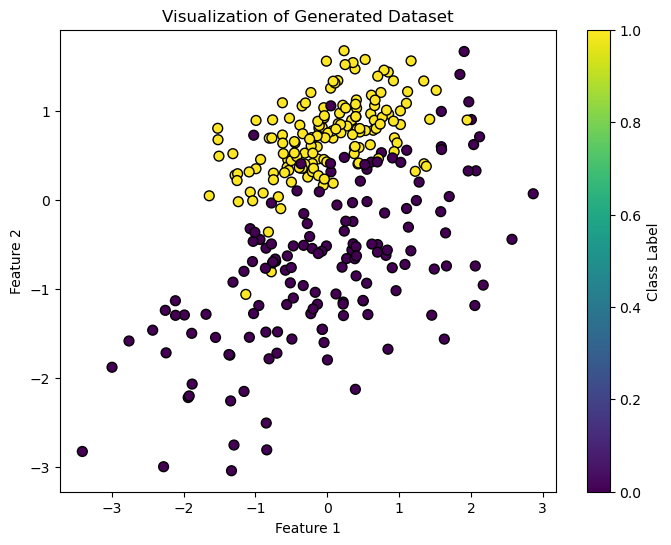

In [70]:
# Generate and visualize linearly separable data
linearX, linearY = generate_dataset(dataset_type='linearly_separable')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(linearX[:, 0], linearX[:, 1], c=linearY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set would be easy to split with a line. Unsurprising, since it is called "linearly separable."

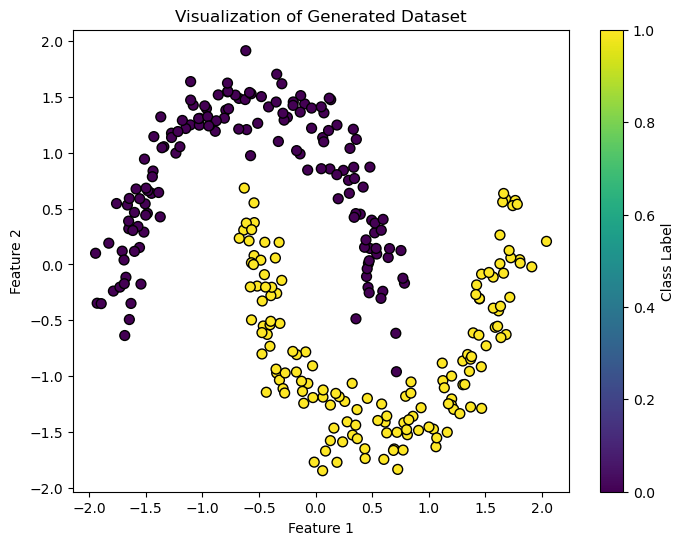

In [71]:
# Generate and visualize moons data set
moonsX, moonsY = generate_dataset(dataset_type='moons')

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(moonsX[:, 0], moonsX[:, 1], c=moonsY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set would be very easy to classify with a non-linear classifier.

0
1


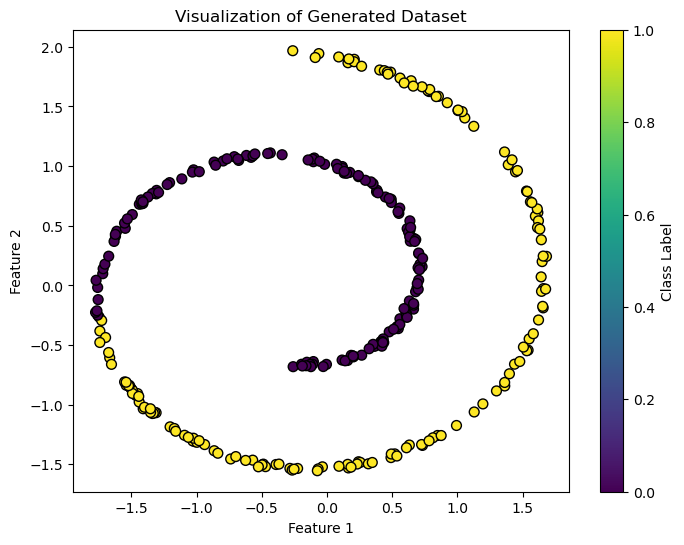

In [72]:
# Generate and visualize swiss roll with 2 split sets
swissX, swissY = generate_dataset(dataset_type='swiss', split=2)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(swissX[:, 0], swissX[:, 1], c=swissY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set would be hard to classify with a non-linear classifer still, because the yellow class "wraps around" the purple one creating non-linearity, but easy to classify with some non-linear kernel SVM.

0
1


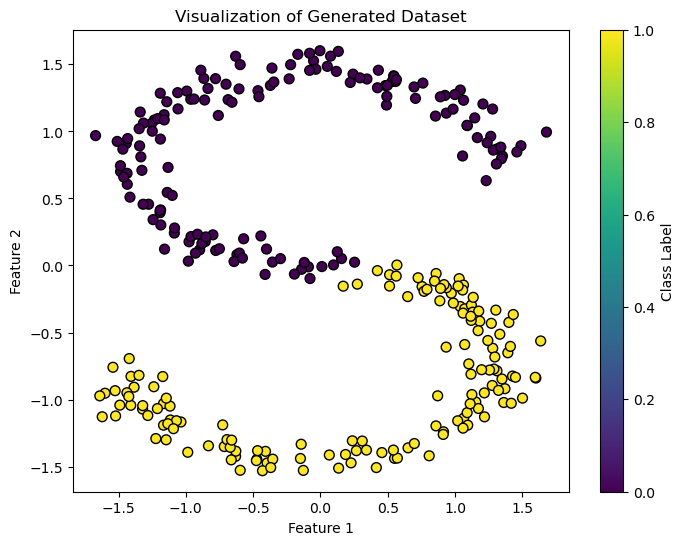

In [73]:
# Generate and visualize S curve with 2 split sets
scurveX, scurveY = generate_dataset(dataset_type='scurve', split=2)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(scurveX[:, 0], scurveX[:, 1], c=scurveY, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set would be easy to classify with a linear classifier, as it is easy to split the two halves of an S with a line, corresponding to the two labels.

0
1
2
3
4
5
6
7
8
9


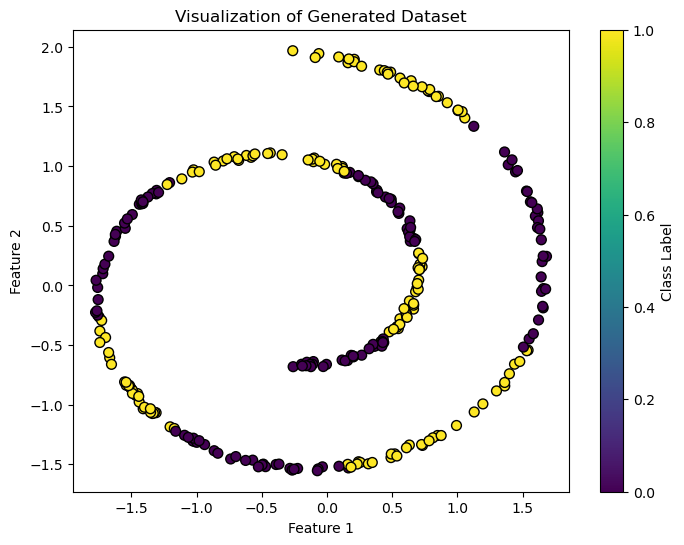

In [74]:
# Generate and visualize swiss role with 10 split sets
swiss10X, swiss10Y = generate_dataset(dataset_type='swiss', split=10)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(swiss10X[:, 0], swiss10X[:, 1], c=swiss10Y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set will be hard to classify linearly. Perhaps there is a sinusoidal kernel trick that would help it classify with a non-linear classifier.

0
1
2
3
4
5
6
7
8
9


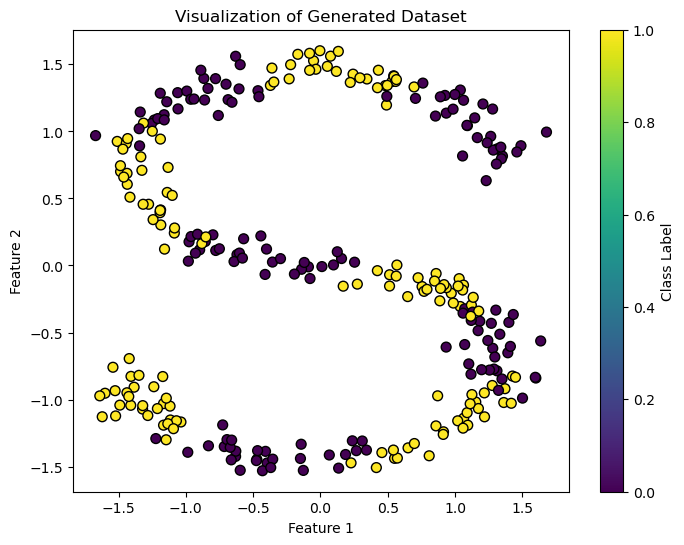

In [75]:
# Generate and visualize S curve with 10 split sets
scurve10X, scurve10Y = generate_dataset(dataset_type='scurve', split=10)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(scurve10X[:, 0], scurve10X[:, 1], c=scurve10Y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Generated Dataset')
plt.colorbar(label='Class Label')
plt.show()

#### I anticipate that this data set will be hard to classify with a linear classifier. However, several almost vertical lines will do pretty well at splitting this dataset. 

### Part 1.2: SVM with nonlinear kernels

The next cell defines the function `kernel_comparison`, which you can use to visually compare the decision boundaries generated by SVMs with different kernels. 

1. The kernel comparison currently produces only visual results. Add code to the function so that it also outputs train and test accuracy of the different SVMs. (Note: Think carefully about where the right place in the code is to do a train-test split.)
2. Run the kernel comparison for the data sets from Part 1.1. Do the results confirm or contradict your expectations that you formulated in Part 1.1.? Did any of the results surprise you?
3. Consult sklearn's documentation to learn how the keyword arguments `degree` and `gamma` affect your classifier. Try out a few different values of these parameters. How and what can one infer from the shape of the decision boundary about the classifier's `degree` or `gamma`?

In [76]:
#FUNCTION MODIFICATIONS:
#   train test split + accuracy
#   arguments for degree and gamma for Q3

def kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=False, degree=3, gamma='scale'):
    fig = plt.figure(figsize=(10,3))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    accuracies = {'train': [], 'test': []}

    for ikernel, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # Train the SVC
        clf = svm.SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X_train, y_train)

        # Predict and calculate accuracy
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        accuracies['train'].append(train_accuracy)
        accuracies['test'].append(test_accuracy)

        # Settings for plotting
        ax = plt.subplot(1, 4, 1 + ikernel)
    
        # Plot decision boundary and margins
        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )
    
        if support_vectors:
            # Plot bigger circles around samples that serve as support vectors
            ax.scatter(
                clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150,
                facecolors="none",
                edgecolors="k",
            )
    
        # Plot samples by color and add legend
        ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
        ax.set_title(f'{kernel}\nTrain: {train_accuracy:.2f}, Test: {test_accuracy:.2f}')
        ax.axis('off')
        if tight_box:
            ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
            ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

    plt.tight_layout()
    plt.show()

    print("\nTrain and Test Accuracies:")
    for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        print(f"{kernel.capitalize()} kernel:")
        print(f"  Train Accuracy: {accuracies['train'][i]:.2f}")
        print(f"  Test Accuracy: {accuracies['test'][i]:.2f}")


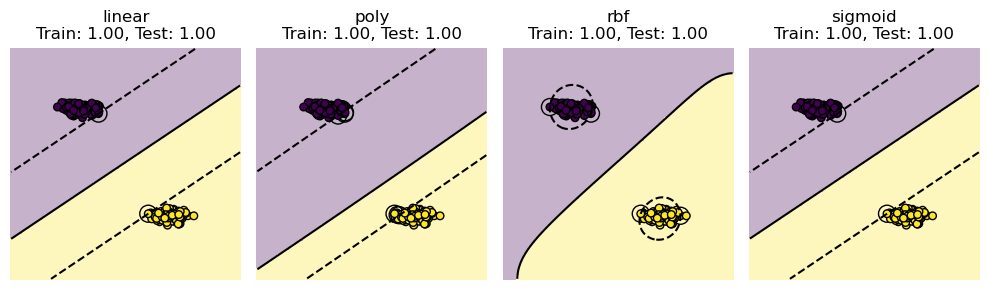


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 1.00
  Test Accuracy: 1.00
Poly kernel:
  Train Accuracy: 1.00
  Test Accuracy: 1.00
Rbf kernel:
  Train Accuracy: 1.00
  Test Accuracy: 1.00
Sigmoid kernel:
  Train Accuracy: 1.00
  Test Accuracy: 1.00


In [77]:
# Show results of kernel comparison for data sets from part 1
kernel_comparison(blobsX, blobsY)

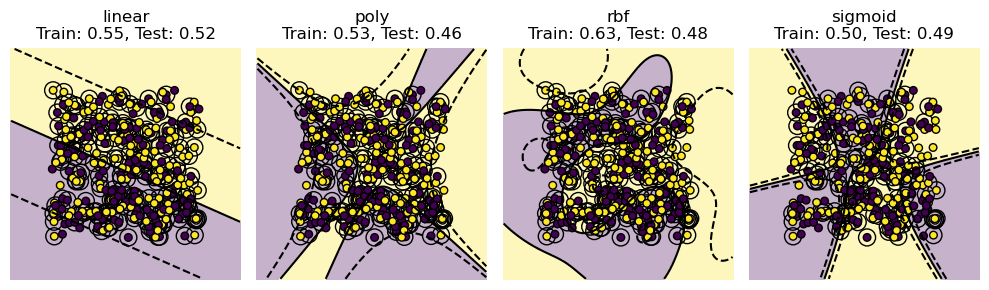


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.55
  Test Accuracy: 0.52
Poly kernel:
  Train Accuracy: 0.53
  Test Accuracy: 0.46
Rbf kernel:
  Train Accuracy: 0.63
  Test Accuracy: 0.48
Sigmoid kernel:
  Train Accuracy: 0.50
  Test Accuracy: 0.49


In [78]:
kernel_comparison(unstructuredX, unstructuredY)

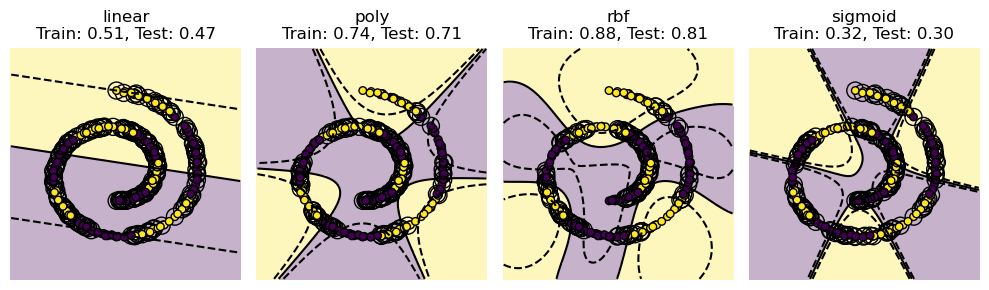


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.47
Poly kernel:
  Train Accuracy: 0.74
  Test Accuracy: 0.71
Rbf kernel:
  Train Accuracy: 0.88
  Test Accuracy: 0.81
Sigmoid kernel:
  Train Accuracy: 0.32
  Test Accuracy: 0.30


In [79]:
kernel_comparison(swiss10X, swiss10Y)

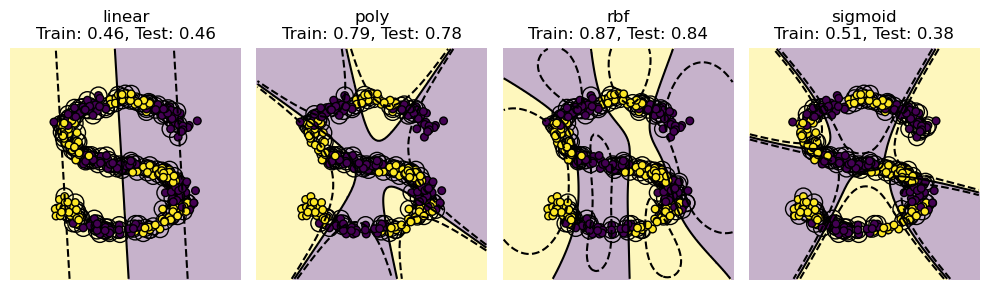


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.46
  Test Accuracy: 0.46
Poly kernel:
  Train Accuracy: 0.79
  Test Accuracy: 0.78
Rbf kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.84
Sigmoid kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.38


In [80]:
kernel_comparison(scurve10X, scurve10Y)

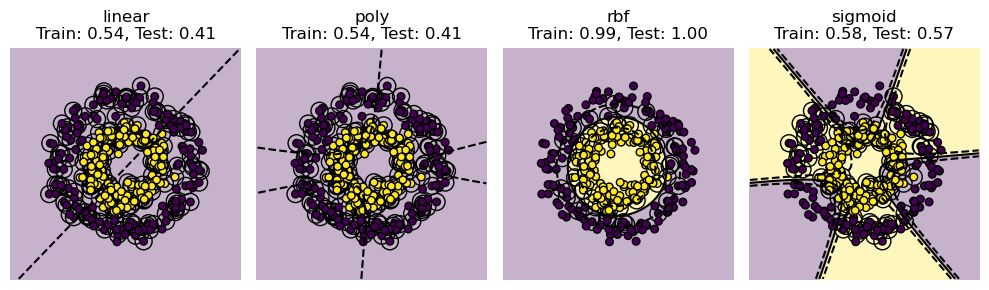


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.54
  Test Accuracy: 0.41
Poly kernel:
  Train Accuracy: 0.54
  Test Accuracy: 0.41
Rbf kernel:
  Train Accuracy: 0.99
  Test Accuracy: 1.00
Sigmoid kernel:
  Train Accuracy: 0.58
  Test Accuracy: 0.57


In [81]:
kernel_comparison(circlesX, circlesY)

#### To summarize the results of the kernel comparison, for certain datasets, which are linearly separable, it doesn't matter what kernel we choose: all do excellently. If the data sets are inherently extremely noisy, again, all kernel will do poorly, like with the unstructured dataset. On all other datasets, especially the curvy ones, RBF kernel seems to outperform all other kernels consistently, and linear kernels do the worst, unsurprisingly. When the class labels are arranged in ring-like strusture, only RBF kernel can classify them extremely accurately, while other kernel tricks fail.

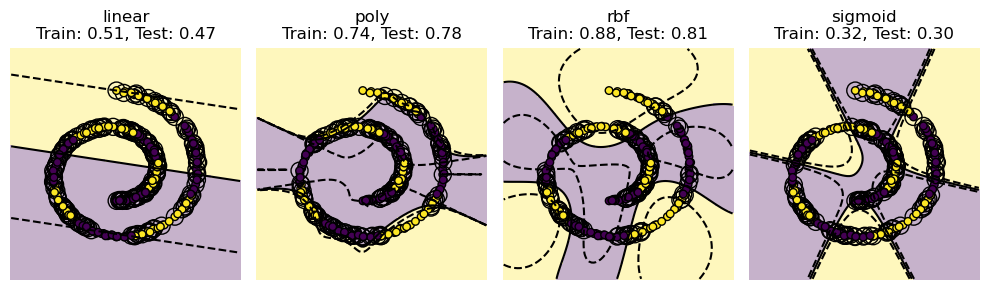


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.47
Poly kernel:
  Train Accuracy: 0.74
  Test Accuracy: 0.78
Rbf kernel:
  Train Accuracy: 0.88
  Test Accuracy: 0.81
Sigmoid kernel:
  Train Accuracy: 0.32
  Test Accuracy: 0.30


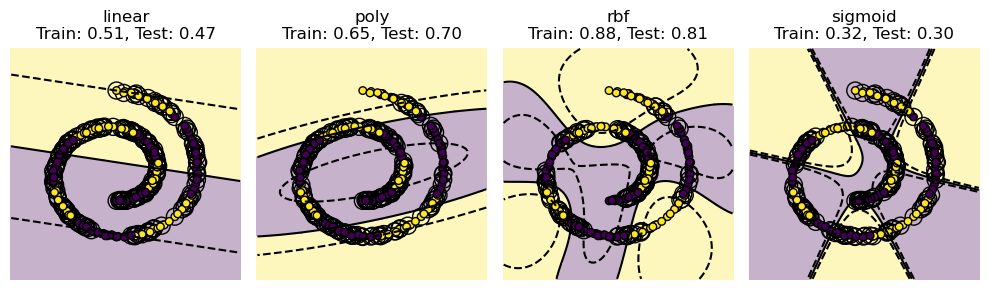


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.47
Poly kernel:
  Train Accuracy: 0.65
  Test Accuracy: 0.70
Rbf kernel:
  Train Accuracy: 0.88
  Test Accuracy: 0.81
Sigmoid kernel:
  Train Accuracy: 0.32
  Test Accuracy: 0.30


In [82]:
# Examine effect of degree and gamma keyword
kernel_comparison(swiss10X, swiss10Y, degree=10)
kernel_comparison(swiss10X, swiss10Y, degree=2)

#### The `degree` argument is the degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels. The higher the degree, the more complex the model is, since we are including higher degree polynomials, and, hence, the more we overfit. So low bias, high variance.

#### As one increases the `degree`, the decision boundary becomes more and more complex and twisted. Low degree argument results in a smoother decision boundary.

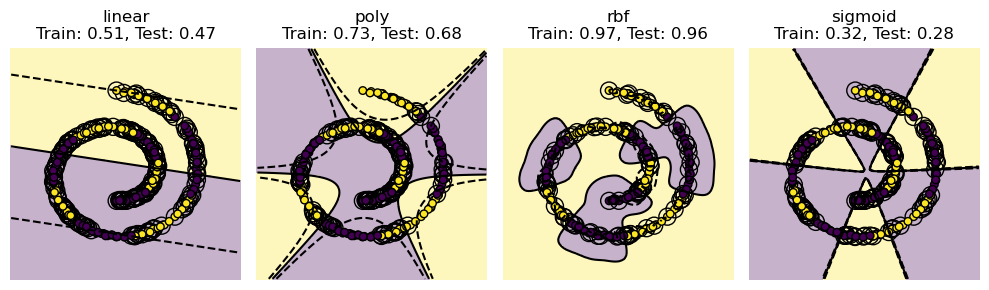


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.47
Poly kernel:
  Train Accuracy: 0.73
  Test Accuracy: 0.68
Rbf kernel:
  Train Accuracy: 0.97
  Test Accuracy: 0.96
Sigmoid kernel:
  Train Accuracy: 0.32
  Test Accuracy: 0.28


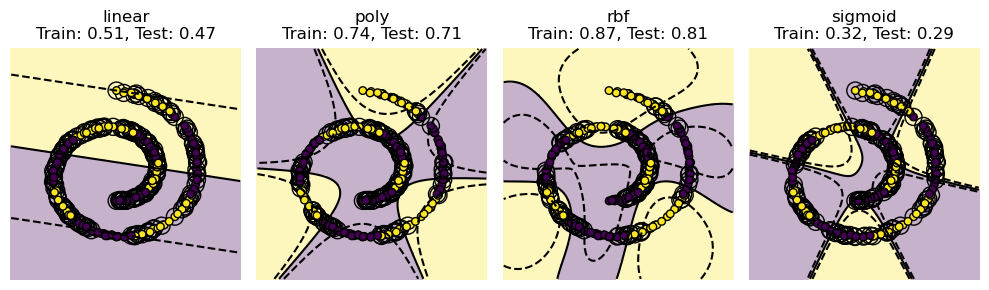


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.51
  Test Accuracy: 0.47
Poly kernel:
  Train Accuracy: 0.74
  Test Accuracy: 0.71
Rbf kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.81
Sigmoid kernel:
  Train Accuracy: 0.32
  Test Accuracy: 0.29


In [83]:
# Examine effect of degree and gamma keyword
kernel_comparison(swiss10X, swiss10Y, gamma=10)
kernel_comparison(swiss10X, swiss10Y, gamma=0.5)

#### The `gamma` is a kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. controls the influence of a single training example and affects the model's complexity. 

#### When gamma is low, the influence of each training example is spread over a larger region, leading to a smoother decision boundary. This often results in a high bias model, which may underfit the training data and have poor performance on both the training and test sets.

#### When gamma is high, the influence of each training example is more localized, leading to a more complex decision boundary that closely fits the training data. This can cause the model to capture noise and fluctuations in the training data, resulting in high variance and potential overfitting.

#### RBF is the clearest example of what is happening in the above runs of kernel comparison with different gamma.

## Part 2: US Flags

### Part 2.1: Load and explore flags data
The function `load_images` loads the image data from the flags folder and turns each image into a binary (i.e., black and white) array.

1. Load the flags data.
2. Display four flags of your choice in a figure. Use the `matplotlib` commands `subplot` and `imshow` to create a figure with 2x2 flags. Consult the `matplotlib` documentation to find a way set the aspect ratio of your displayed flags to match their original aspect ratio. Update your code accordingly.

In [84]:
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert image to black and white
            img = np.array(img)//(256/2) # Convert to BW
            images.append(img)
            labels.append(filename.split('.')[0])  # Extract the state code as label
    return images, labels

# Loading flags
flags_images, flags_states = load_images("flags")

/opt/miniconda3/envs/learning/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


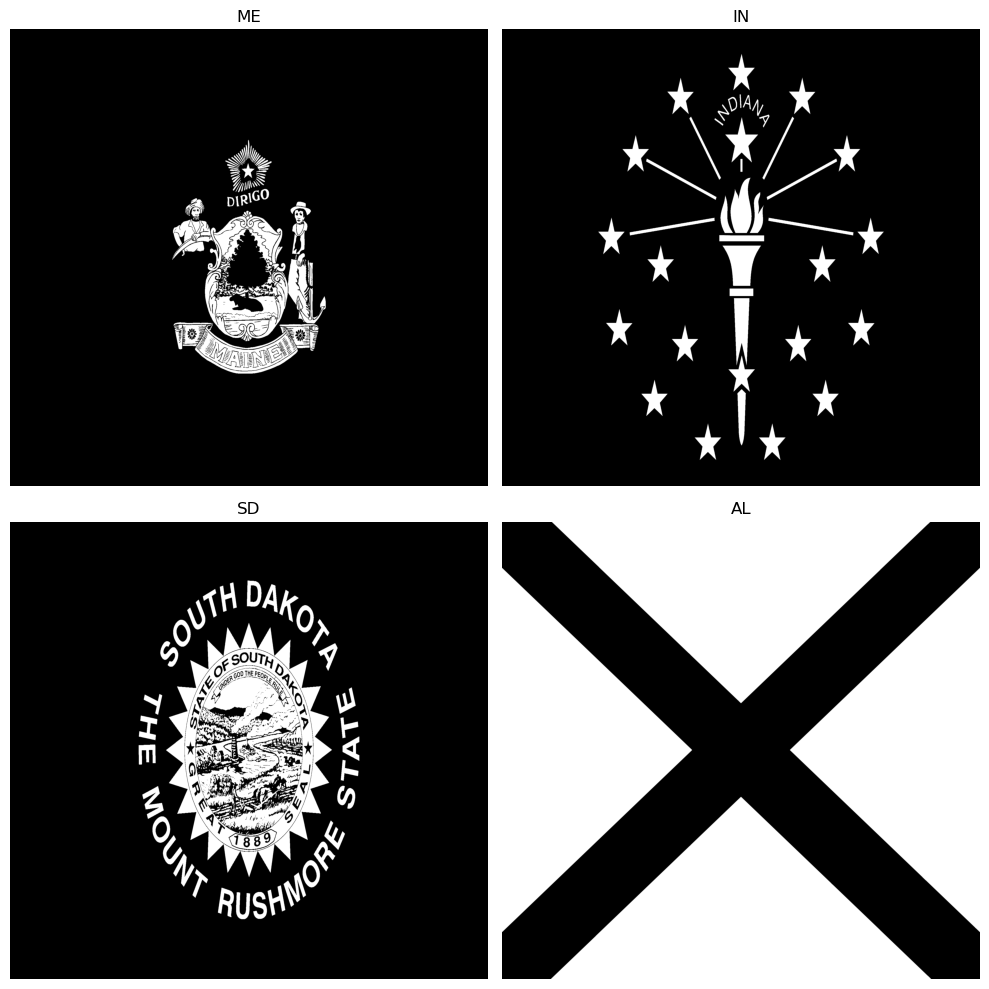

In [85]:
# Display four black-and-white flags in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # Flatten the 2x2 grid into a single array of axes for easier iteration

# Select four flags to display
selected_indices = [1, 17, 23, 39]  # Pick 4 random flags
for i, idx in enumerate(selected_indices):
    img = flags_images[idx]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(flags_states[idx].upper()) # let's use all caps for state codes as per convention
    axs[i].axis('off')
    axs[i].set_aspect(aspect='auto')  # Preserve original aspect ratio

plt.tight_layout()
plt.show()

### Part 2.2: SVMs for flag pixel data
The function `sample_pixels` samples a pixel from a given image uniformly at random. 

1. Use the `sample_pixels`  function to generate synthetic data sets of pixels from for a flag image.
2. Update the `kernel_comparison` function so that if `if_flag` is `True` the decision boundaries are plotted in a 2x2 grid of subplots with plot ranges matching the height and width of the flags.
3. Show the results of the kernel comparison for the four flags that your previously selected. Use the highest values of `degree` and `gamma` that still run *reasonably fast* on your laptop.
4. Adjust your code so that you can run the quantitative part (i.e., the calculation of train and test accuracy) without plotting the decision boundaries. Run the adjusted code on all flags to indentify for each kernel the flags that yield to best easiest-to-classify and hardest-to-classify data sets. Test how the number of of pixels sampled affects your results.

In [86]:
def sample_pixels(image, num_samples=100):
    pixel_data = []
    pixel_labels = []
    height, width = image.shape
    for _ in range(num_samples):
        x1 = random.randint(0, width - 1)
        x2 = random.randint(0, height - 1)
        pixel_data.append([x1/width-0.5, x2/width-0.5])
        pixel_labels.append(image[x2,x1])
    return np.array(pixel_data), np.array(pixel_labels, dtype=int)

In [87]:
# In case we need to display 4 flags a couple of times, let's turn the code for part 2.1 into a function

def display_flags(images, labels, indices):
    if len(indices) != 4:
        raise ValueError("Exactly 4 indices are required")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()  # Flatten the 2x2 grid into a single array of axes for easier iteration

    for i, idx in enumerate(indices):
        img = images[idx]
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(labels[idx].upper())  # Convert title to all caps
        axs[i].axis('off')
        axs[i].set_aspect(aspect='auto')  # Preserve original aspect ratio

    plt.tight_layout()
    plt.show()

# Display four flags using the function
# Commented out, testing completed
# selected_indices = [1, 17, 23, 39]  # Change indices to select different flags
# display_flags(flags_images, flags_states, selected_indices)

In [88]:
# Updated kernel_comparison function
def kernel_comparison_flag_update(X, y, support_vectors=True, tight_box=False, if_flag=False, degree=3, gamma='scale', plot=True):
    fig = plt.figure(figsize=(10, 10)) if plot else None

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    accuracies = {'train': [], 'test': []}
    kernel_accuracies = {'linear': [], 'poly': [], 'rbf': [], 'sigmoid': []}

    for ikernel, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # Train the SVC
        clf = svm.SVC(kernel=kernel, degree=degree, gamma=gamma).fit(X_train, y_train)

        # Predict and calculate accuracy
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        accuracies['train'].append(train_accuracy)
        accuracies['test'].append(test_accuracy)
        kernel_accuracies[kernel].append(test_accuracy)

        if plot:
            # Settings for plotting
            ax = plt.subplot(2, 2, 1 + ikernel) if if_flag else plt.subplot(1, 4, 1 + ikernel)
        
            # Plot decision boundary and margins
            common_params = {"estimator": clf, "X": X, "ax": ax}
            DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="predict",
                plot_method="pcolormesh",
                alpha=0.3,
            )
            DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="decision_function",
                plot_method="contour",
                levels=[-1, 0, 1],
                colors=["k", "k", "k"],
                linestyles=["--", "-", "--"],
            )
        
            if support_vectors:
                # Plot bigger circles around samples that serve as support vectors
                ax.scatter(
                    clf.support_vectors_[:, 0],
                    clf.support_vectors_[:, 1],
                    s=150,
                    facecolors="none",
                    edgecolors="k",
                )
        
            # Plot samples by color and add legend
            ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
            ax.set_title(f'{kernel}\nTrain: {train_accuracy:.2f}, Test: {test_accuracy:.2f}')
            ax.axis('off')
            if tight_box:
                ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
                ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

    if plot:
        plt.tight_layout()
        plt.show()

    print("\nTrain and Test Accuracies:")
    for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        print(f"{kernel.capitalize()} kernel:")
        print(f"  Train Accuracy: {accuracies['train'][i]:.2f}")
        print(f"  Test Accuracy: {accuracies['test'][i]:.2f}")
    
    return kernel_accuracies



 RESULTS FOR FLAG: ME


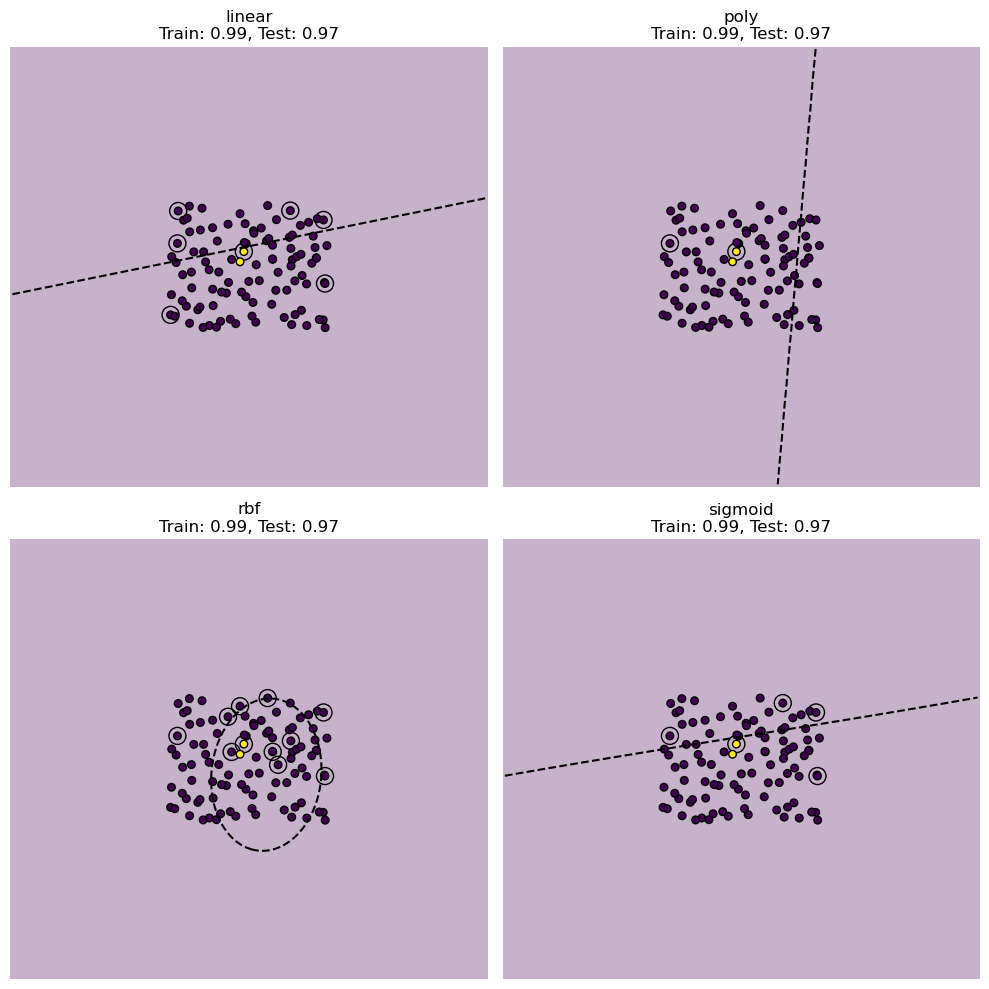


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.99
  Test Accuracy: 0.97
Poly kernel:
  Train Accuracy: 0.99
  Test Accuracy: 0.97
Rbf kernel:
  Train Accuracy: 0.99
  Test Accuracy: 0.97
Sigmoid kernel:
  Train Accuracy: 0.99
  Test Accuracy: 0.97

 RESULTS FOR FLAG: IN


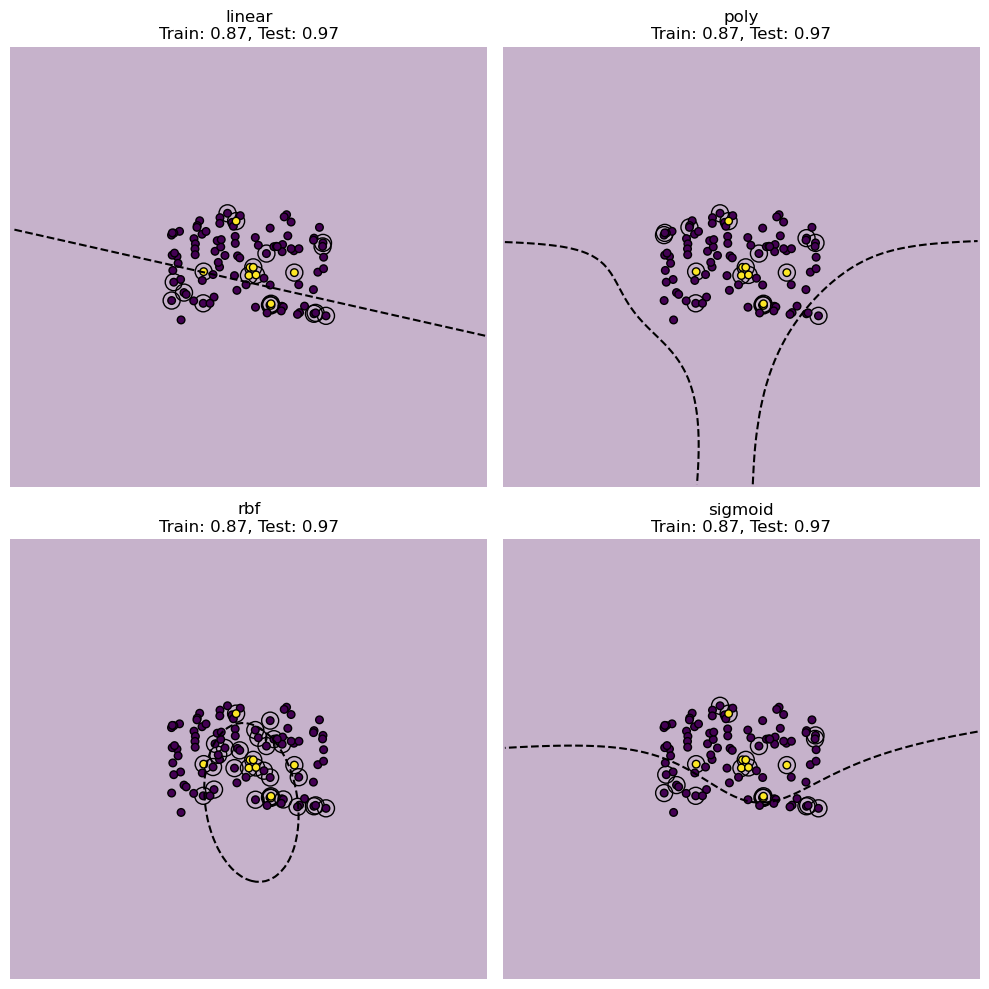


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.97
Poly kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.97
Rbf kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.97
Sigmoid kernel:
  Train Accuracy: 0.87
  Test Accuracy: 0.97

 RESULTS FOR FLAG: SD


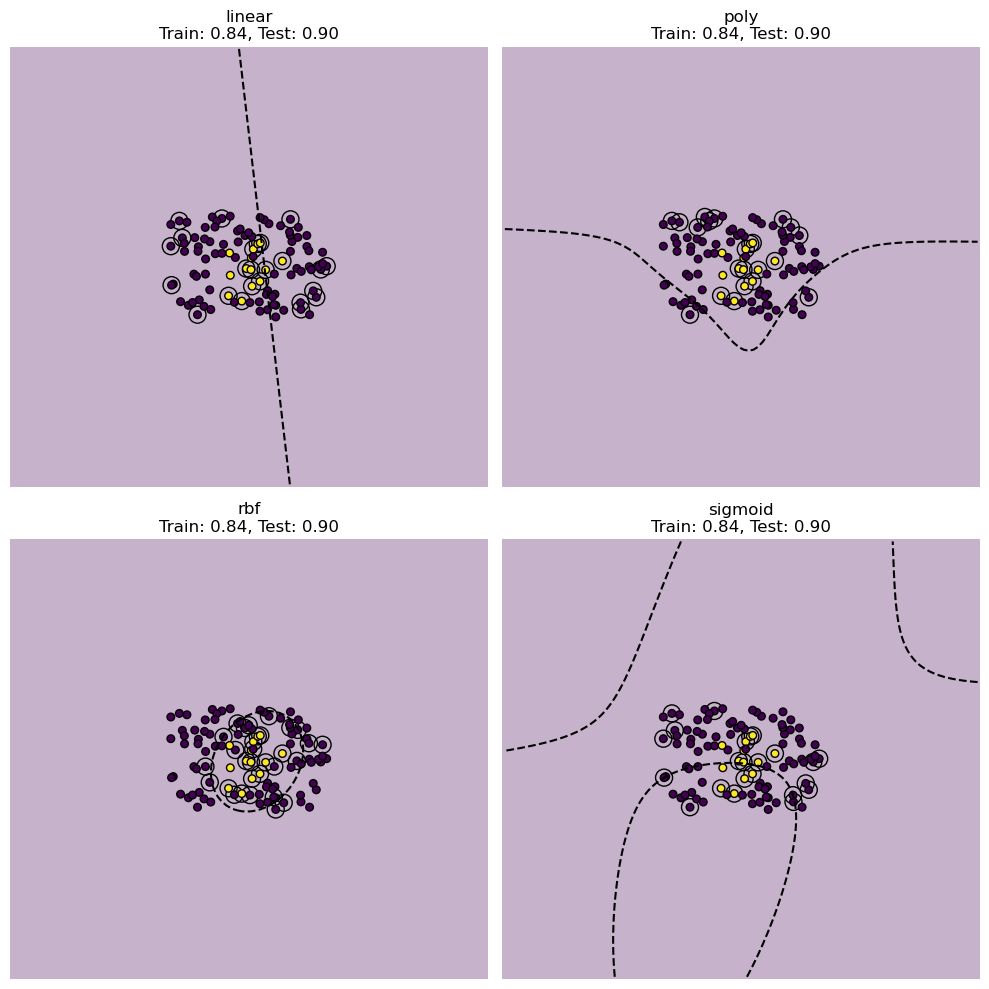


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.84
  Test Accuracy: 0.90
Poly kernel:
  Train Accuracy: 0.84
  Test Accuracy: 0.90
Rbf kernel:
  Train Accuracy: 0.84
  Test Accuracy: 0.90
Sigmoid kernel:
  Train Accuracy: 0.84
  Test Accuracy: 0.90

 RESULTS FOR FLAG: AL


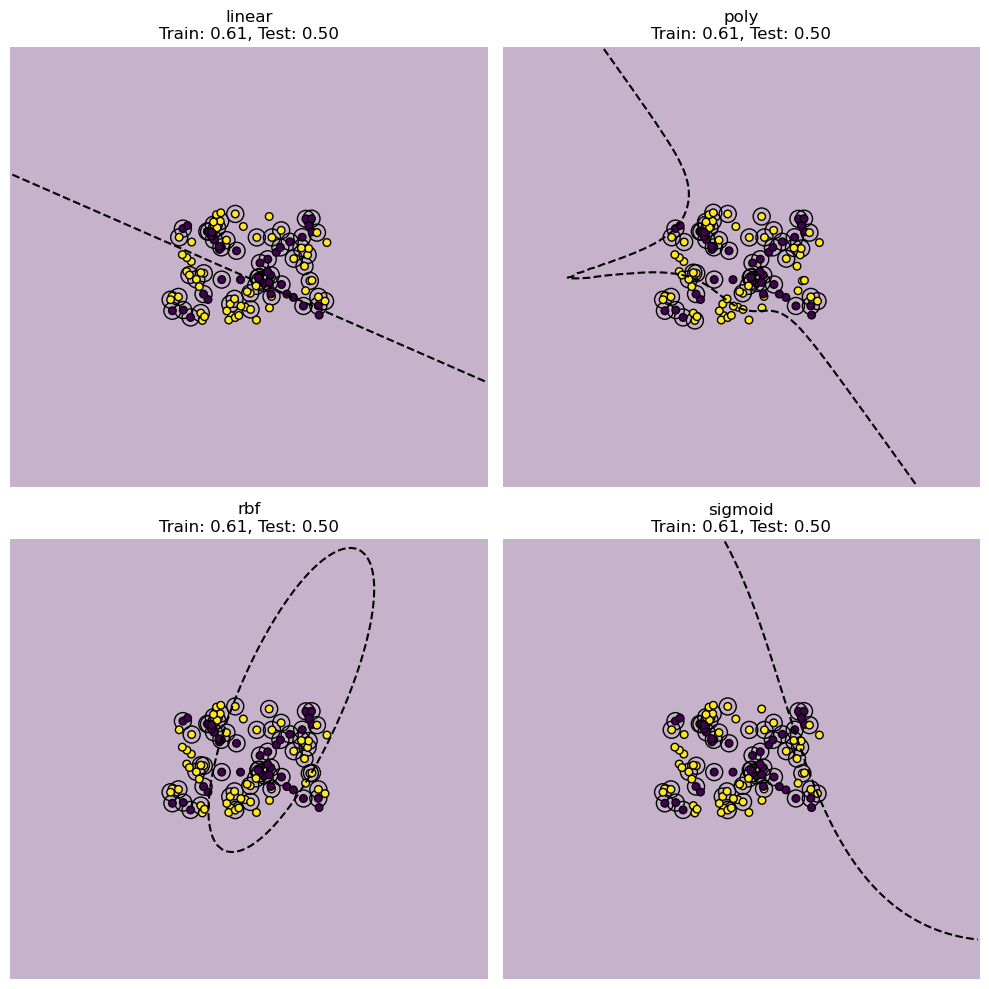


Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.61
  Test Accuracy: 0.50
Poly kernel:
  Train Accuracy: 0.61
  Test Accuracy: 0.50
Rbf kernel:
  Train Accuracy: 0.61
  Test Accuracy: 0.50
Sigmoid kernel:
  Train Accuracy: 0.61
  Test Accuracy: 0.50


In [89]:
# Visual kernel comparison for selected flags
for idx in selected_indices:
    X, y = sample_pixels(flags_images[idx], num_samples=100)  # Adjust num_samples as needed
    print(f"\n RESULTS FOR FLAG: {flags_states[idx].upper()}")
    sorted_accuracies = kernel_comparison_flag_update(X, y, if_flag=True, degree=5, gamma=0.1)  # more complex decision boundary but no overfitting since train and test accuracies are close to each other and are high


In [90]:
# Non-visual kernel comparison for all flags
all_kernel_accuracies = {'linear': [], 'poly': [], 'rbf': [], 'sigmoid': []}
for idx, image in enumerate(flags_images):
    X, y = sample_pixels(image, num_samples=1000)  # Adjust num_samples as needed
    print(f"\nFLAG: {flags_states[idx].upper()}")
    kernel_accuracies = kernel_comparison_flag_update(X, y, if_flag=False, degree=5, gamma=0.1, plot=False)
    for kernel in all_kernel_accuracies:
        for acc in kernel_accuracies[kernel]:
            all_kernel_accuracies[kernel].append((acc, flags_states[idx]))

print("All kernel accuracies:")
for kernel, accuracies in all_kernel_accuracies.items():
    sorted_accuracies = sorted(accuracies, key=lambda x: x[0])
    print(f"{kernel.capitalize()} kernel: {sorted_accuracies}")


FLAG: UT

Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.90
  Test Accuracy: 0.91
Poly kernel:
  Train Accuracy: 0.90
  Test Accuracy: 0.91
Rbf kernel:
  Train Accuracy: 0.90
  Test Accuracy: 0.91
Sigmoid kernel:
  Train Accuracy: 0.90
  Test Accuracy: 0.91

FLAG: ME

Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.95
  Test Accuracy: 0.96
Poly kernel:
  Train Accuracy: 0.95
  Test Accuracy: 0.96
Rbf kernel:
  Train Accuracy: 0.95
  Test Accuracy: 0.96
Sigmoid kernel:
  Train Accuracy: 0.95
  Test Accuracy: 0.96

FLAG: LA

Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.85
  Test Accuracy: 0.81
Poly kernel:
  Train Accuracy: 0.85
  Test Accuracy: 0.81
Rbf kernel:
  Train Accuracy: 0.85
  Test Accuracy: 0.81
Sigmoid kernel:
  Train Accuracy: 0.85
  Test Accuracy: 0.81

FLAG: CO

Train and Test Accuracies:
Linear kernel:
  Train Accuracy: 0.74
  Test Accuracy: 0.77
Poly kernel:
  Train Accuracy: 0.74
  Test Accuracy: 0.77
Rbf kernel:
  Train Ac

For these experiments, I set `num_samples` to 1000 because the results of the experiments seem to be the most stable for this number of sampled pixels.

The linear kernel performed best (i.e., highest test accuracy) on the flags of the following three states: 

AK, NV, RI

It performed worst on the flags of the following three states: 

MD, FL, AL

The polynomial kernel performed best on the flags of the following three states: 

AK, RI, NV

It performed worst on the flags of the following three states: 

MD, FL, NC

The radial-basis function kernel performed best on the flags of the following three states: 

AK, RI, NV

It performed worst on the flags of the following three states: 

MD, FL, AL

The sigmoid kernel performed best on the flags of the following three states: 

AK, RI, NV

It performed worst on the flags of the following three states:

MD, FL, AL

### Part 2.3: Comparison to decision trees
Decision trees and SVMs yield substantially different decision boundaries.

1. An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set. Explain why.
2. For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy as well. Explain why.
3. Select four flags for which you anticipate a *simple* decision tree to outperform all your SVMs. Write code that fits a decision tree to a flag pixel data set. Use your code to check your hypothesis. 

An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set, because it can create a unique path from the root to a leaf for each training data point. The each leaf node will represent a single data point or a perfectly classified small subset of data points. Thus, the tree will have a specific rule for every single data point, ensuring it will be classified correctly.

For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy because the extensive variety of pixel patterns in a large dataset helps the tree to learn and apply precise decision boundaries for flag classification, enhancing its accuracy on unseen test samples. This is because the large dataset ensures comprehensive coverage and accurate representation of the underlying class distributions, i.e., flags, which reduces the risk of overfitting.

A simple decision tree is likely to perform well on the sampled pixel data of the flags of IA, HI, MS, OR.

In [91]:
# Comparison of SVM and decision tree performance on sampled pixel data for four flags

from sklearn.tree import DecisionTreeClassifier

# Function to compare decision tree with SVMs
def compare_models(X, y, flag_state, degree=3, gamma='scale'):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Train and evaluate the decision tree
    dt_clf = DecisionTreeClassifier(max_depth=3)  # Simple decision tree we used before in HW
    dt_clf.fit(X_train, y_train)
    dt_y_test_pred = dt_clf.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_y_test_pred)
    
    # Train and evaluate SVMs
    accuracies_svm = {}
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        svm_clf = svm.SVC(kernel=kernel, degree=degree, gamma=gamma)
        svm_clf.fit(X_train, y_train)
        svm_y_test_pred = svm_clf.predict(X_test)
        svm_accuracy = accuracy_score(y_test, svm_y_test_pred)
        accuracies_svm[kernel] = svm_accuracy
    
    # Display results
    print(f"Flag: {flag_state.upper()}")
    print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
    for kernel, accuracy in accuracies_svm.items():
        print(f"{kernel.capitalize()} Kernel SVM Accuracy: {accuracy:.2f}")
    print()

In [92]:
# Select states where decision trees are likely to outperform SVMs
selected_labels = ['ia', 'hi', 'ms', 'or']

# Find indices for the selected labels
selected_indices = [i for i, label in enumerate(flags_states) if label in selected_labels]

# Compare models on selected flags
for idx in selected_indices:
    X, y = sample_pixels(flags_images[idx], num_samples=1000) 
    compare_models(X, y, flags_states[idx])

Flag: MS
Decision Tree Accuracy: 0.87
Linear Kernel SVM Accuracy: 0.83
Poly Kernel SVM Accuracy: 0.83
Rbf Kernel SVM Accuracy: 0.83
Sigmoid Kernel SVM Accuracy: 0.73

Flag: HI
Decision Tree Accuracy: 0.86
Linear Kernel SVM Accuracy: 0.60
Poly Kernel SVM Accuracy: 0.60
Rbf Kernel SVM Accuracy: 0.60
Sigmoid Kernel SVM Accuracy: 0.51

Flag: IA
Decision Tree Accuracy: 0.91
Linear Kernel SVM Accuracy: 0.56
Poly Kernel SVM Accuracy: 0.59
Rbf Kernel SVM Accuracy: 0.88
Sigmoid Kernel SVM Accuracy: 0.31

Flag: OR
Decision Tree Accuracy: 0.91
Linear Kernel SVM Accuracy: 0.91
Poly Kernel SVM Accuracy: 0.91
Rbf Kernel SVM Accuracy: 0.91
Sigmoid Kernel SVM Accuracy: 0.87



I looked at all [US state flags](https://www.wikiwand.com/en/Flags_of_the_U.S._states_and_territories), and looked carefully at those on which SVM did poorly. I figured that the ones that have similar patterns to other flags, like stripes or being all blue with a complex center image, will be hard to classify. However, a decision tree might be able to capture some of the finer detail, so I figured it would better than SVMs on the above four flags, which indeed turned out to be true.